# **ML en PySpark - Procesamiento de Datos**

Pontificia Universidad Javeriana - 2410

Samuel Peña García - ID - 20486979

Programa: Ciencia de Datos

Clase: 8184

###¿Qué es un ictus?
*El accidente cerebrovascular o ictus es una condición médica grave que ocurre cuando el flujo de sangre a una parte del cerebro se interrumpe o reduce, privando al tejido cerebral de oxígeno y nutrientes esenciales. Es uno de los motivos más frecuentes de asistencia neurológica urgente, provocado por un trastorno de la circulación cerebral.*

Fuente: https://www.cun.es/enfermedades-tratamientos/enfermedades/ictus

Descripción en el dataset:

- **id**
- **gender**
- **age**
- **hypertension**
- **heart_disease**: Bool
- **ever_married**
- **work_type**
- **Residence_type**: Urban / Rural
- **avg_glucose_level**: Nivel de glucosa promedio (float)
- **bmi**: Índice de masa corporal (float)
- **smoking_status**: Unknown // Never Smoke // Formerly Smoke // Smokes
- **stroke**: Variable target (Tendencias a tener ictus)

In [0]:
#se importan las librerías necesarias para la sesión de PySpark y para realizar procesos de Machine Learning
import pyspark
from pyspark import SparkContext
from pyspark.sql import SQLContext, Row
from pyspark.sql.functions import *
from pyspark.sql.types import *
import pandas as pd
from pyspark.ml.feature import *
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import *
from pyspark.mllib.evaluation import BinaryClassificationMetrics as Metricas


#Se importan otras librerías importantes como sklearn, numpy, seaborn y matplotlib
from sklearn.metrics import *
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import *

In [0]:
#Se levanta la sesión Spark
sc = SparkContext.getOrCreate()
sql_sc = SQLContext(sc)
sc

/databricks/spark/python/pyspark/sql/context.py:117: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


<SparkContext master=local[8] appName=Databricks Shell>

In [0]:
#Se extrae la base de datos y se convierte en un dataframe
url = "https://raw.githubusercontent.com/corredor-john/EDA_Varios/main/Health00.csv"
pandasDF = pd.read_csv(url)
mldf00 = spark.createDataFrame(pandasDF)

In [0]:
mldf00.limit(5).toPandas()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [0]:
mldf00.printSchema()

root
 |-- id: long (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: long (nullable = true)
 |-- heart_disease: long (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: long (nullable = true)



In [0]:
mldf00 = mldf00.drop('id')

In [0]:
mldf00.printSchema()

root
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: long (nullable = true)
 |-- heart_disease: long (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: long (nullable = true)



In [0]:
#Se revisa la cantidad de valores nulos en el conjunto
mldf00.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in mldf00.columns]).show()

+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
|gender|age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level|bmi|smoking_status|stroke|
+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
|     0|  0|           0|            0|           0|        0|             0|                0|201|             0|     0|
+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+



In [0]:
###Se observa que hay 201 valores nulos en la variable "bmi"
#Se realiza la transformación para llenar los valores nulos con el promedio de la variable bmi
promBMI = mldf00.agg(mean('bmi')).collect()[0][0]
mldf00 = mldf00.fillna(promBMI, subset = ['bmi'])

In [0]:

mldf00.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in mldf00.columns]).show()

+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
|gender|age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level|bmi|smoking_status|stroke|
+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
|     0|  0|           0|            0|           0|        0|             0|                0|  0|             0|     0|
+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+



In [0]:
#Se realiza una agrupación respecto a las variables gender, smoking_status, ever_married, work_type y Residence_type, que son variables categóricas
mldf00.groupBy("gender").count().show()
mldf00.groupBy("smoking_status").count().show()
mldf00.groupBy("ever_married").count().show()
mldf00.groupBy("work_type").count().show()
mldf00.groupBy("Residence_type").count().show()

+------+-----+
|gender|count|
+------+-----+
|Female| 2994|
|  Male| 2115|
| Other|    1|
+------+-----+

+---------------+-----+
| smoking_status|count|
+---------------+-----+
|         smokes|  789|
|        Unknown| 1544|
|   never smoked| 1892|
|formerly smoked|  885|
+---------------+-----+

+------------+-----+
|ever_married|count|
+------------+-----+
|          No| 1757|
|         Yes| 3353|
+------------+-----+

+-------------+-----+
|    work_type|count|
+-------------+-----+
| Never_worked|   22|
|Self-employed|  819|
|      Private| 2925|
|     children|  687|
|     Govt_job|  657|
+-------------+-----+

+--------------+-----+
|Residence_type|count|
+--------------+-----+
|         Urban| 2596|
|         Rural| 2514|
+--------------+-----+



In [0]:
###Se elimina el other de las categorías de la columna gender por su baja tasa de aparición
mldf00 = mldf00.filter(mldf00.gender != 'Other')

In [0]:
#Se revisa la transformación
mldf00.groupBy("gender").count().show()

+------+-----+
|gender|count|
+------+-----+
|Female| 2994|
|  Male| 2115|
+------+-----+



In [0]:
mldf00.columns

['gender',
 'age',
 'hypertension',
 'heart_disease',
 'ever_married',
 'work_type',
 'Residence_type',
 'avg_glucose_level',
 'bmi',
 'smoking_status',
 'stroke']

<Axes: xlabel='gender', ylabel='count'>

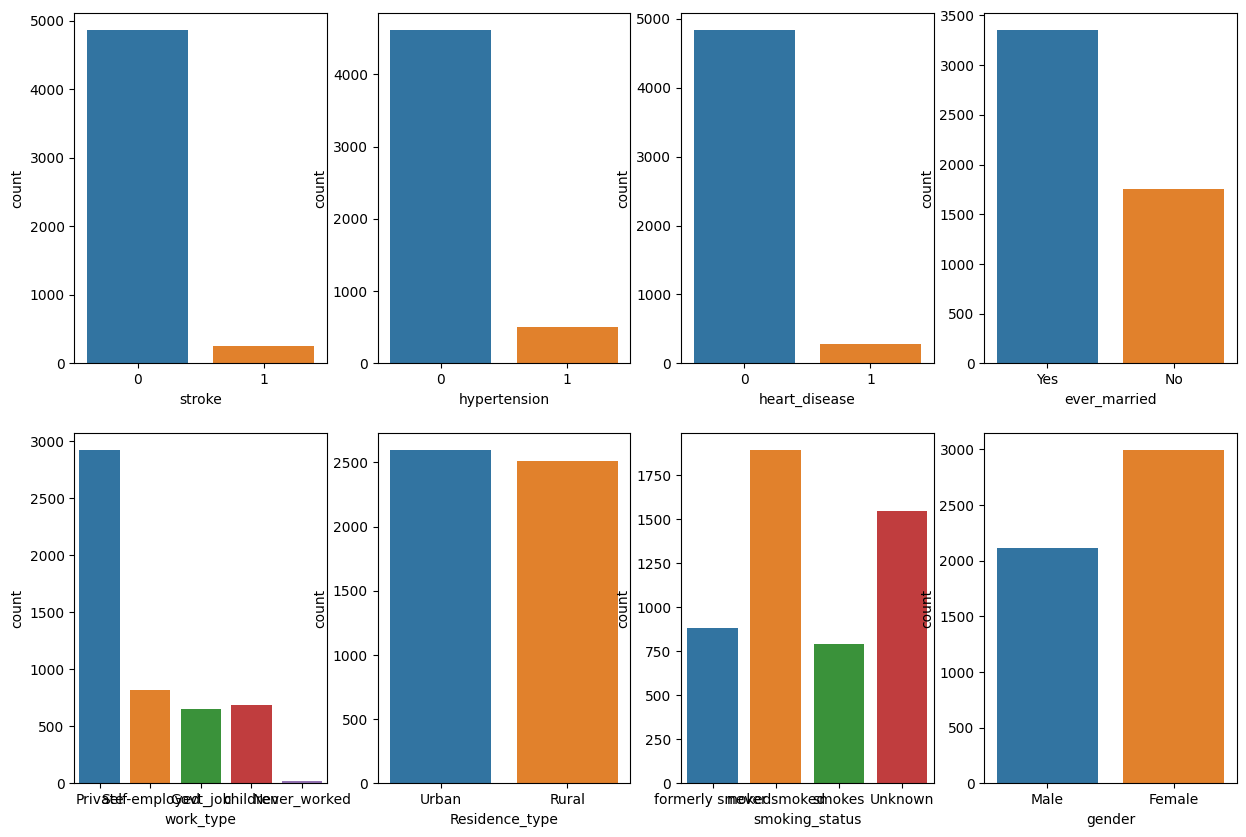

In [0]:
###Se grafican las variables categóricas
pDF = mldf00.toPandas()
fig, axes = plt.subplots(2, 4, figsize = (15, 10))
sns.countplot(data = pDF, x = 'stroke', ax = axes[0,0])
sns.countplot( data = pDF, x = 'hypertension', ax = axes[0,1])
sns.countplot( data = pDF, x = 'heart_disease', ax = axes[0,2])
sns.countplot( data = pDF, x = 'ever_married', ax = axes[0,3])
sns.countplot( data = pDF, x = 'work_type', ax = axes[1,0])
sns.countplot( data = pDF, x = 'Residence_type', ax = axes[1,1])
sns.countplot( data = pDF, x = 'smoking_status', ax = axes[1,2])
sns.countplot( data = pDF, x = 'gender', ax = axes[1,3])

<Axes: title={'center': 'Distribución del bmi'}, xlabel='bmi', ylabel='Count'>

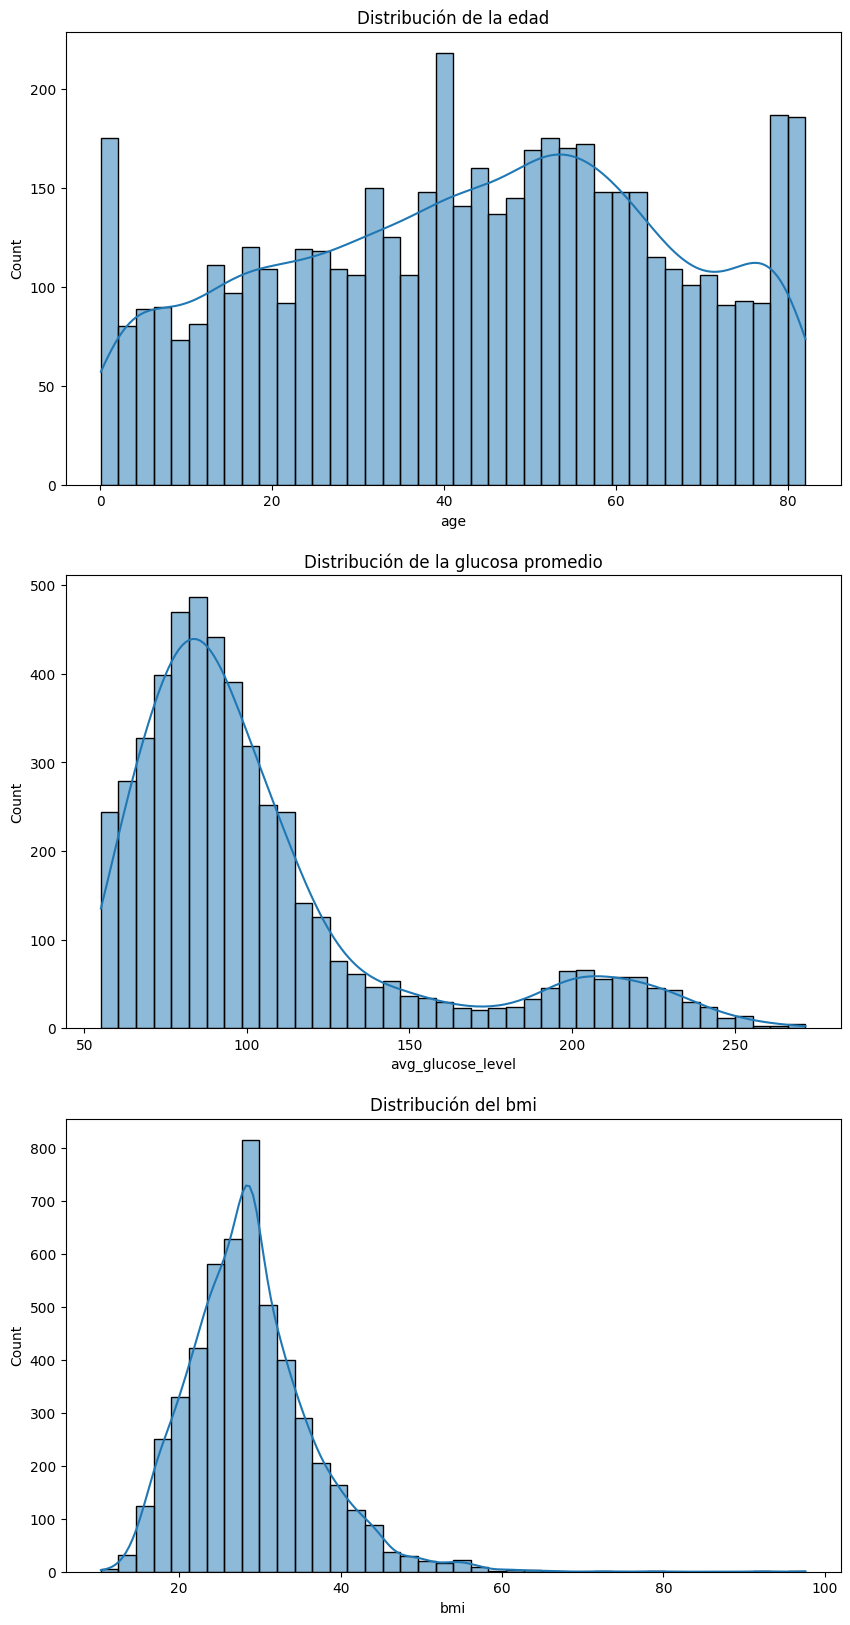

In [0]:
##Se grafican las variables numéricas

fig, axes = plt.subplots(3, 1, figsize = (10,20))
axes[0].set_title("Distribución de la edad")
sns.histplot(pDF['age'], bins = 40, kde = True, ax = axes[0])
axes[1].set_title("Distribución de la glucosa promedio")
sns.histplot(pDF['avg_glucose_level'], bins = 40, kde = True, ax = axes[1])
axes[2].set_title("Distribución del bmi")
sns.histplot(pDF['bmi'], bins = 40, kde = True, ax = axes[2])

/databricks/python/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


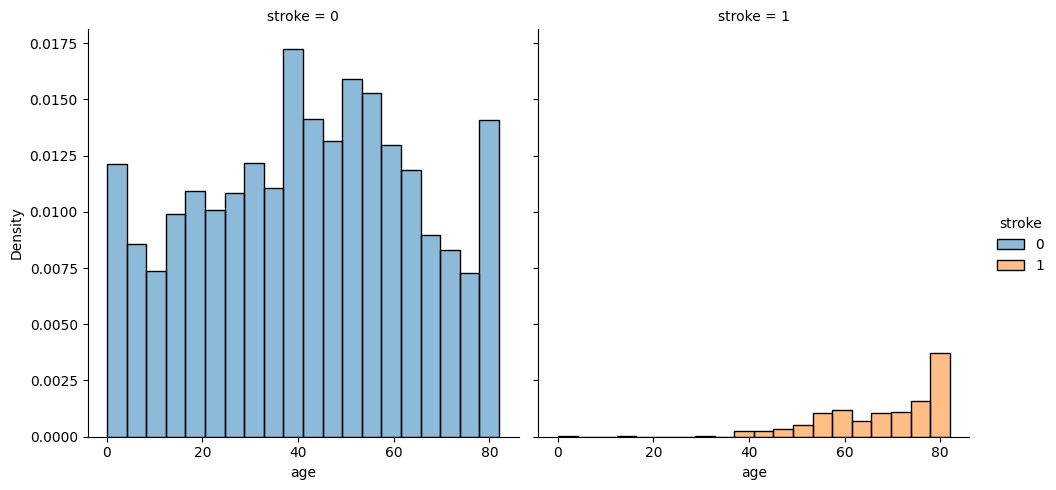

In [0]:
###Se muestra la distribución de la variable stroke con relación a la variable age
sns.displot(pDF, x = 'age', hue = 'stroke', col = 'stroke', stat = 'density')

/databricks/python/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


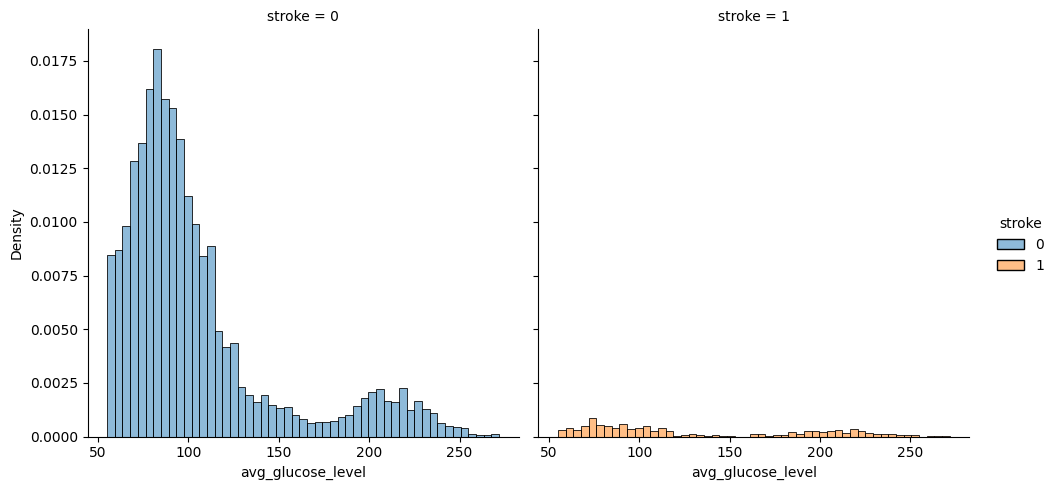

In [0]:
###Se muestra la distribución de la variable stroke con relación al nivel promedio de glucosa.
sns.displot(pDF, x = 'avg_glucose_level', hue = 'stroke', col = 'stroke', stat = 'density')

In [0]:
#Se añade una columna Alto Riesgo para pacientes con edad igual o superior a 40 y nivel promedio de glucosa inferior a 125
mldf00 = mldf00.withColumn('Alto_Riesgo', when((col('age') >= 40) & (col('avg_glucose_level') <= 125),1).otherwise(0))
mldf00.limit(5).toPandas()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,Alto_Riesgo
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1,0
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1,0
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1,0
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1,0


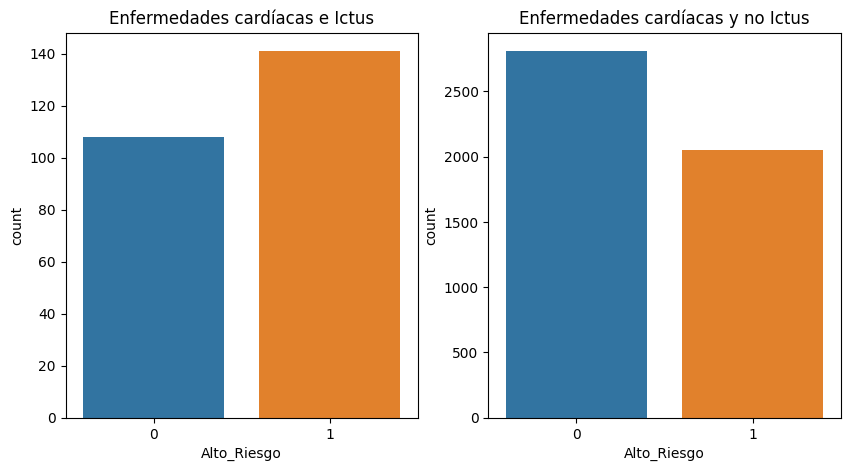

In [0]:
#Relación entre enfermedades cardíacas e Ictus
fig, axes = plt.subplots(1, 2, figsize=(10,5))

axes[0].set_title('Enfermedades cardíacas e Ictus', fontsize=12)
ax0 = sns.countplot(data=mldf00.toPandas().loc[pDF['stroke'] == 1], x='Alto_Riesgo', ax=axes[0])

axes[1].set_title('Enfermedades cardíacas y no Ictus', fontsize=12)
ax1 = sns.countplot(data=mldf00.toPandas().loc[pDF['stroke'] == 0], x='Alto_Riesgo', ax=axes[1])

In [0]:
#Relación entre enfermedades cardíacas e Ictus
fig, axes = plt.subplots(1, 2, figsize=(10,5))

axes[0].set_title('Heart disease and strokes', fontsize=12)
ax0 = sns.countplot(data=mldf00.toPandas().loc[pDF['stroke'] == 1], x='Alto_Riesgo', ax=axes[0])

axes[1].set_title('Heart disease and no strokes', fontsize=12)
ax1 = sns.countplot(data=mldf00.toPandas().loc[pDF['stroke'] == 0], x='Alto_Riesgo', ax=axes[1])

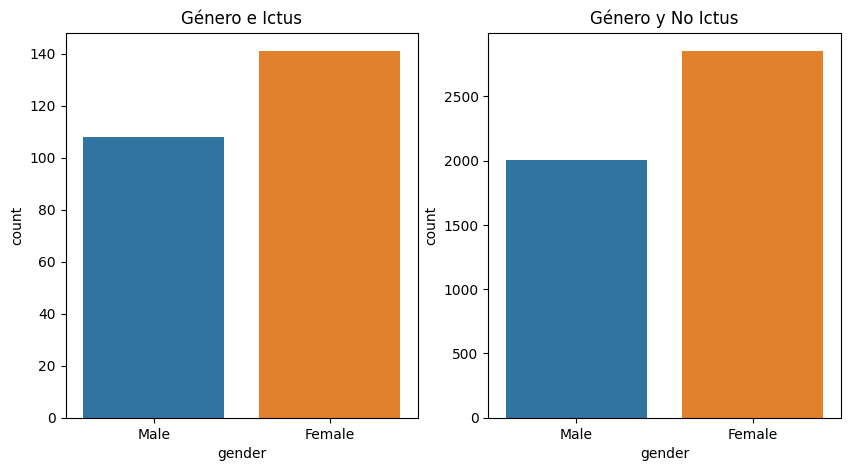

In [0]:
#Relación entre Genero e Ictus
fig, axes = plt.subplots(1, 2, figsize=(10,5))

axes[0].set_title('Género e Ictus', fontsize=12)
ax0 = sns.countplot(data=mldf00.toPandas().loc[pDF['stroke'] == 1], x='gender', ax=axes[0])

axes[1].set_title('Género y No Ictus', fontsize=12)
ax1 = sns.countplot(data=mldf00.toPandas().loc[pDF['stroke'] == 0], x='gender', ax=axes[1])

In [0]:
#.collect()[1][0]
mldf00.select('gender').distinct().show()
mldf00.select('ever_married').distinct().show()
mldf00.select('work_type').distinct().show()
mldf00.select('Residence_type').distinct().show()
mldf00.select('smoking_status').distinct().show()
#Se elimina la columna "id"
mldf00 = mldf00.drop("id")

+------+
|gender|
+------+
|Female|
|  Male|
+------+

+------------+
|ever_married|
+------------+
|          No|
|         Yes|
+------------+

+-------------+
|    work_type|
+-------------+
| Never_worked|
|Self-employed|
|      Private|
|     children|
|     Govt_job|
+-------------+

+--------------+
|Residence_type|
+--------------+
|         Urban|
|         Rural|
+--------------+

+---------------+
| smoking_status|
+---------------+
|         smokes|
|        Unknown|
|   never smoked|
|formerly smoked|
+---------------+



**Se convierten las categorias *string* a datos numéricos**

In [0]:
###Categorias a Indices
noCategoricos = ['age','hypertension','heart_disease','avg_glucose_level','bmi','stroke', 'Alto_Riesgo']
indices = [StringIndexer(inputCol=column, outputCol=column+"_IND").fit(mldf00) for column in list(set(mldf00.columns)-set(noCategoricos))]

pipeML = Pipeline(stages=indices)
mldf00 = pipeML.fit(mldf00).transform(mldf00)

####Columnas a eliminar del dataset categoricas
borraSet = ['gender','ever_married','work_type','Residence_type','smoking_status']
mldf00 = mldf00.drop(*borraSet)

mldf00.show(5)

+----+------------+-------------+-----------------+------------------+------+-----------+----------------+------------------+-------------+----------+------------------+
| age|hypertension|heart_disease|avg_glucose_level|               bmi|stroke|Alto_Riesgo|ever_married_IND|smoking_status_IND|work_type_IND|gender_IND|Residence_type_IND|
+----+------------+-------------+-----------------+------------------+------+-----------+----------------+------------------+-------------+----------+------------------+
|67.0|           0|            1|           228.69|              36.6|     1|          0|             0.0|               2.0|          0.0|       1.0|               0.0|
|61.0|           0|            0|           202.21|28.893236911794656|     1|          0|             0.0|               0.0|          1.0|       0.0|               1.0|
|80.0|           0|            1|           105.92|              32.5|     1|          1|             0.0|               0.0|          0.0|       1.0|

**VectorAssembler**

Transformador de características que fusiona varias columnas en una columna vectorial.

In [0]:
feature = VectorAssembler(inputCols = mldf00.drop('stroke').columns, outputCol='features')

feature_vector = feature.transform(mldf00)
feature_vector.show(3)

+----+------------+-------------+-----------------+------------------+------+-----------+----------------+------------------+-------------+----------+------------------+--------------------+
| age|hypertension|heart_disease|avg_glucose_level|               bmi|stroke|Alto_Riesgo|ever_married_IND|smoking_status_IND|work_type_IND|gender_IND|Residence_type_IND|            features|
+----+------------+-------------+-----------------+------------------+------+-----------+----------------+------------------+-------------+----------+------------------+--------------------+
|67.0|           0|            1|           228.69|              36.6|     1|          0|             0.0|               2.0|          0.0|       1.0|               0.0|(11,[0,2,3,4,7,9]...|
|61.0|           0|            0|           202.21|28.893236911794656|     1|          0|             0.0|               0.0|          1.0|       0.0|               1.0|(11,[0,3,4,8,10],...|
|80.0|           0|            1|           1

In [0]:
display(feature_vector.select("features"))

features
"Map(vectorType -> sparse, length -> 11, indices -> List(0, 2, 3, 4, 7, 9), values -> List(67.0, 1.0, 228.69, 36.6, 2.0, 1.0))"
"Map(vectorType -> sparse, length -> 11, indices -> List(0, 3, 4, 8, 10), values -> List(61.0, 202.21, 28.893236911794656, 1.0, 1.0))"
"Map(vectorType -> dense, length -> 11, values -> List(80.0, 0.0, 1.0, 105.92, 32.5, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0))"
"Map(vectorType -> sparse, length -> 11, indices -> List(0, 3, 4, 7), values -> List(49.0, 171.23, 34.4, 3.0))"
"Map(vectorType -> sparse, length -> 11, indices -> List(0, 1, 3, 4, 8, 10), values -> List(79.0, 1.0, 174.12, 24.0, 1.0, 1.0))"
"Map(vectorType -> sparse, length -> 11, indices -> List(0, 3, 4, 7, 9), values -> List(81.0, 186.21, 29.0, 2.0, 1.0))"
"Map(vectorType -> dense, length -> 11, values -> List(74.0, 1.0, 1.0, 70.09, 27.4, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0))"
"Map(vectorType -> sparse, length -> 11, indices -> List(0, 3, 4, 5, 6), values -> List(69.0, 94.39, 22.8, 1.0, 1.0))"
"Map(vectorType -> sparse, length -> 11, indices -> List(0, 3, 4, 5, 7, 10), values -> List(59.0, 76.15, 28.893236911794656, 1.0, 1.0, 1.0))"
"Map(vectorType -> sparse, length -> 11, indices -> List(0, 3, 4, 5, 7), values -> List(78.0, 58.57, 24.2, 1.0, 1.0))"


##División datos entrenamiento y prueba

In [0]:
dfML03 = feature_vector.select(['features', 'stroke'])
train, test = dfML03.randomSplit([0.8,0.2])

##Regresión logística


In [0]:
from pyspark.ml.classification import LogisticRegression

LogReg = LogisticRegression(featuresCol="features", labelCol="stroke")
modeloLReg = LogReg.fit(train)

- Coeficientes e Intercepto del Modelo de Regresión Logísitica

In [0]:
coeficientes = modeloLReg.coefficients
intercepto   = modeloLReg.intercept
print("Coeficientes: ", coeficientes)
print("Intercepto: ", intercepto)

Coeficientes:  [0.07048173836510811,0.47427464545027703,0.15083920741414758,0.003107587063420874,-0.00048520102412991117,-0.1405760248443441,0.2733180029193375,0.10602846687956805,-0.14615126675449022,0.07143668107025439,-0.016783026571787953]
Intercepto:  -7.452356301014842


- Evaluación del modelo en los datos de prueba

AUC-ROC: Area bajo la curva de Receiver Operating Characteristics. 
      - ROC es una curva de probabilidad y AUC representa el grado o medida de separabilidad. Indica hasta qué punto el modelo es capaz de distinguir entre clases. Cuanto mayor es el AUC, mejor es el modelo para predecir las clases 0 como 0 y las clases 1 como 1. 

In [0]:
predicciones = modeloLReg.transform(test)
resultados = predicciones.select(['probability', 'stroke'])

resultadosColecc = resultados.collect()
resultadosLista = [(float(i[0][0]), 1.0-float(i[1])) for i in resultadosColecc]
puntuaciones = sc.parallelize(resultadosLista)

In [0]:
#Impresión de Métricas
metricas    = Metricas(puntuaciones)
AUC         = metricas.areaUnderROC
Accuracy    = MulticlassClassificationEvaluator(labelCol='stroke', metricName='accuracy').evaluate(predicciones)
Precision   = MulticlassClassificationEvaluator(labelCol='stroke', metricName='weightedPrecision').evaluate(predicciones)
Recall      = MulticlassClassificationEvaluator(labelCol='stroke', metricName='weightedRecall').evaluate(predicciones)


print(f"AUC-ROC: {AUC:.4f}")
print(f"Accuracy: {Accuracy:.4f}")
print(f"Precision: {Precision:.4f}")
print(f"Recall: {Recall:.4f}")

/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


AUC-ROC: 0.8474
Accuracy: 0.9487
Precision: 0.9001
Recall: 0.9487


- Un valor AUC-ROC alto (cercano a 1) indica que el modelo puede distinguir eficazmente entre las dos clases (ictus y no ictus).
- La exactitud, la precisión y la recuperación nos proporcionan información adicional sobre el rendimiento del modelo al cuantificar en qué medida clasifica correctamente las muestras y con qué frecuencia realiza predicciones falsas positivas o falsas negativas.

##Random Forest

In [0]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

randomF = RandomForestClassifier(labelCol = 'stroke')

paramsG = ParamGridBuilder().addGrid(randomF.maxDepth, [5,10,20]).addGrid(randomF.maxBins, [20,32,50]).build()

tvs = TrainValidationSplit(estimator = randomF,
                           estimatorParamMaps=paramsG,
                           evaluator=MulticlassClassificationEvaluator(labelCol='stroke'),
                           parallelism=1, seed=42, trainRatio=0.8)

modeloRF = tvs.fit(train)
modeloRF_Pred


In [0]:
resultadosRF = modeloRF_Pred.select(['probability '])

resultadosRF_collect = resultadosRF.collect()
resultadosLista = [(float(i[0][0]), 1.0-float(i[1])) for i in resultadosRF_collect]
puntuacionEtiquetas = sc.parallelize(resultadosLista)

In [0]:
metricas = metric(puntuacionEtiquetas)
randomF_ACC = round(MulticlassClassificationEvaluator(labelCol = 'stroke', metricName = 'accuracy').evaluate)